In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression,ElasticNet,ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

plt.style.use('ggplot')
%matplotlib inline

In [59]:
df=pd.read_csv('AmesDummiesOrdinalF.csv',index_col=0)
df=df.drop('Heating_OthW',axis=1)

In [60]:
df.shape

(1458, 72)

In [61]:
SalePrice=df.SalePrice
net_df=df.drop('SalePrice',axis=1)

In [62]:
'''The function to standardize the columns seperately. 
df - is the dataframe needs the standardization.  
collist - is the list of columns which need to be standardized'''


def standize_df(df,collist):
    for col in collist:
        stan_df=df[[col]]
        min_max_scaler = preprocessing.MinMaxScaler()
        standardized=min_max_scaler.fit_transform(stan_df)
        stan2_df=pd.DataFrame(standardized,columns=stan_df.columns,index=stan_df.index)
        df[[col]]=stan2_df
    return df


#standardize all columns
collist=list(net_df.columns) 

net_df=standize_df(net_df,collist)
net_df.head()

,TotalSF,TotalBsmtSF,LotArea,GarageArea,LotFrontage,OverallQual,BsmtScore,OverallCond,YearsAgoBuilt,MasVnrArea,...,MSSubClass_50,Street_Grvl,HeatingQC,SaleType_ConLI,MasVnrType_BrkCmn,Foundation_BrkTil,GarageType_Basment,Neighborhood_ClearCr,Neighborhood_NWAmes,Foundation_Slab
Id,,,,,,,,,,,,,,,,,,,,,
1,0.332207,0.266999,0.033420,0.394245,0.150685,0.666667,0.999202,0.500,0.050725,0.12250,...,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.224046,0.393637,0.038795,0.330935,0.202055,0.555556,0.832969,0.875,0.246377,0.00000,...,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.350555,0.286962,0.046507,0.437410,0.160959,0.666667,0.998669,0.500,0.065217,0.10125,...,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.333897,0.235808,0.038561,0.461871,0.133562,0.666667,0.830577,0.500,0.688406,0.00000,...,0.0,0.0,0.75,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.450024,0.357143,0.060576,0.601439,0.215753,0.777778,0.999110,0.500,0.072464,0.21875,...,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# Split the df into a 80% train-set and a 20% test set.
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size= 292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))
trainX = net_df.iloc[trainIdxes]
testX  = net_df.iloc[testIdxes]
trainY = SalePrice.iloc[trainIdxes]
testY  = SalePrice.iloc[testIdxes]

In [64]:
net_df.shape

(1458, 71)

In [65]:
net   = ElasticNet()
alphaSize  = 40
rhoSize    = 30
alphaRange = np.linspace(1e-2, 200, alphaSize)
rhoRange   = np.linspace(0.01, 1, rhoSize)
RMSLElist=[]

net.set_params(normalize=False)

for alphaIdx, alpha in enumerate(alphaRange):
    for rhoIdx, rho in enumerate(rhoRange):
        net.set_params(alpha=alpha, l1_ratio=rho)
        net.fit(trainX, trainY)
        PredictionsTest=net.predict(testX)
        RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
        RMSLElist.append([alpha,rho,RMSLEvalue])


In [66]:
a=1.0
for i in range(len(RMSLElist)):
    if RMSLElist[i][2]<a:
        a=RMSLElist[i][2]
        best=RMSLElist[i]
    else:
        continue
        

In [67]:
best

[0.01, 0.5220689655172415, 0.1335945712134445]

In [68]:
# alpha=0.01, rho=0.522, RMSLE = 0.1336

In [71]:
net.set_params(alpha=0.01, l1_ratio=0.5220689655172415)
net.fit(trainX, trainY)
etrain_score=net.score(trainX,trainY)
etest_score=net.score(testX,testY)
PredictionsTest=net.predict(testX)
RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
print ('train_score(R2)\t',etrain_score)
print ('test_score(R2) \t',etest_score)
print ('Elasticnet RMSLE \t',RMSLEvalue)

train_score(R2)	 0.8891381504955432
test_score(R2) 	 0.8983266362068962
Elasticnet RMSLE 	 0.1335945712134445


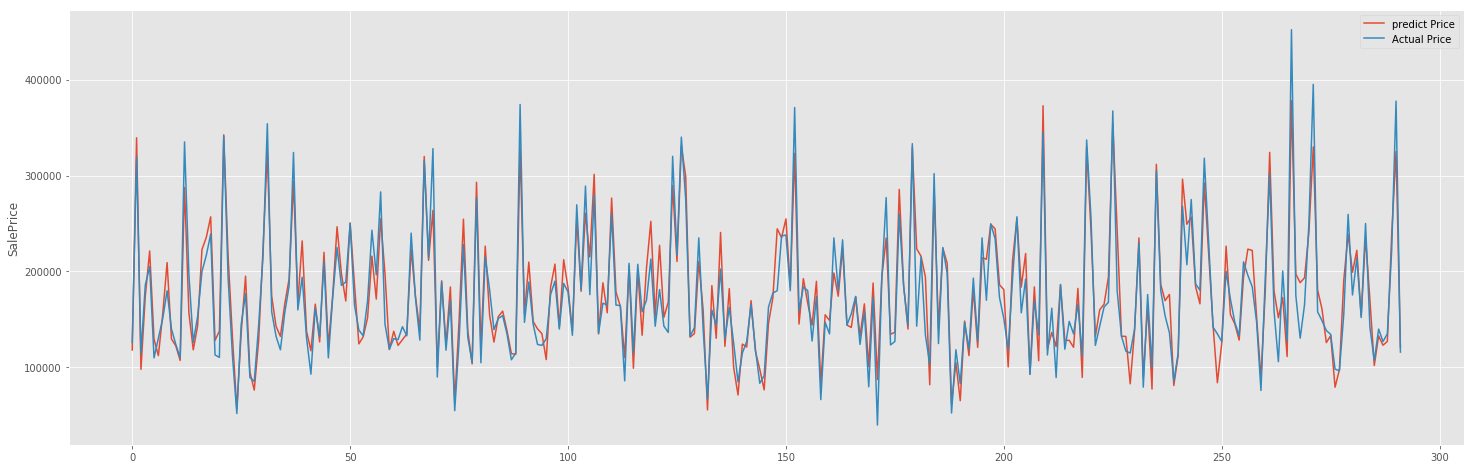

In [72]:
plt.figure(figsize=(25,8))
plt.plot(range(292),PredictionsTest,label="predict Price")
plt.plot(range(292),testY,label="Actual Price")
plt.legend(loc='best')
plt.ylabel('SalePrice')
plt.show()